## Modeling a strong gravitational lens 

Before we continue: Please check if the following libraries are available in your computer:

* numpy: could be installed using pip3(or pip) install numpy
* matplotlib: could be installed using pip3 install matplotlib
* PyAutoLens: Could be isntalled using pip3 install autolens==2022.03.18.2 (Keep in mind that you should have problems to install the latest version)

<img src="https://raw.githubusercontent.com/Jammy2211/PyAutoLens/master/docs/overview/images/lensing/schematic.jpg"  width="700" />

In [1]:
# Some basics libraries
import numpy as np
import matplotlib.pyplot as plt

# Import PyAutoLens module
import autolens as al
import autolens.plot as aplt
import autofit as af

# Also a magic function
%matplotlib inline

### Reading data and usefull constants

In [2]:
# Usefull constants
pixel_scales =  27.9/150 # It defines your pixel-arcseconds transformation (how much arcseconds we have in our cutout?
#In this case, 27.9 equals 150x150 pixels)
exposure_time = 1640.32 # Exposure time of our cutout, could be uselfull to define a noise map of our image
rms_background = 5256.35 # Background rms subtracted, also usefull to estimate noise

In [3]:
# We are going to use a file extension called fits. In these type of files you can store multiple images objects as sub objects called HDU (Header Data Unit)

# In hdu 1, we can find our original image:
original_image = al.Array2D.from_fits(file_path='./data/211527.fits', pixel_scales=pixel_scales, hdu=1)
# In hdu 2, we can find the lens light and other objects. We need this because in most of cases, the lens light is too strong that we can barely see the arcs. This modeling is usually done before this step
lens_light_and_other_objects = al.Array2D.from_fits(file_path='./data/211527.fits', pixel_scales=pixel_scales, hdu=2)
# In hdu 3, we can find the residual and most important image, the residual is composed by the original image - lens light
residual_image = al.Array2D.from_fits(file_path='./data/211527.fits', pixel_scales=pixel_scales, hdu=3)
# PSF or point-spread-function is also important. In simple words, it has information about how much blury your image is...
psf = al.Kernel2D.from_fits(file_path='./data/psf.fits', hdu=0, pixel_scales=pixel_scales)
# In PyAutoLens, we have to set our psf to an odd kernel or shape. In this case a 17x17 one
psf = al.preprocess.array_with_new_shape(array=psf, new_shape=(17, 17))
# We can estimate our noise map by taking a measure of rms background
noise_map = np.sqrt(original_image*exposure_time+rms_background)/exposure_time
# Finally, we combine all these objects in a single one: An imaging object, wich consists of the residual image, noise map and psf
imaging = al.Imaging(image=residual_image, noise_map=noise_map, psf=psf)

### CS82SL013639.16+000818.38 system

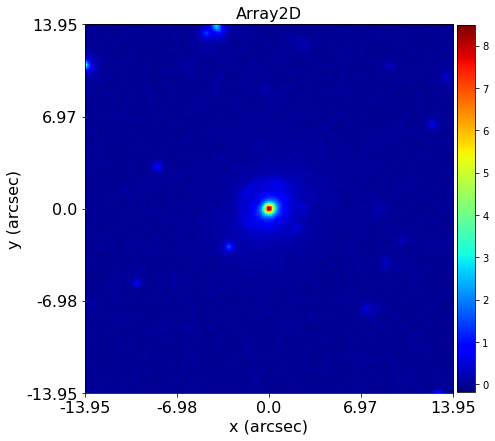

In [4]:
visuals_2d = aplt.Visuals2D()
array_plotter = aplt.Array2DPlotter(array=original_image, visuals_2d=visuals_2d)
array_plotter.figure_2d()

### Lens and other objects light

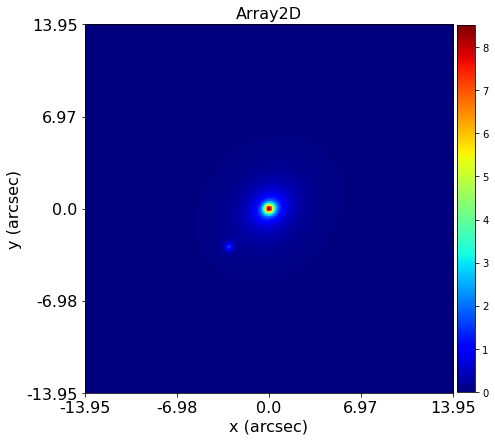

In [5]:
visuals_2d = aplt.Visuals2D()
array_plotter = aplt.Array2DPlotter(array=lens_light_and_other_objects, visuals_2d=visuals_2d)
array_plotter.figure_2d()

### Subtracted image

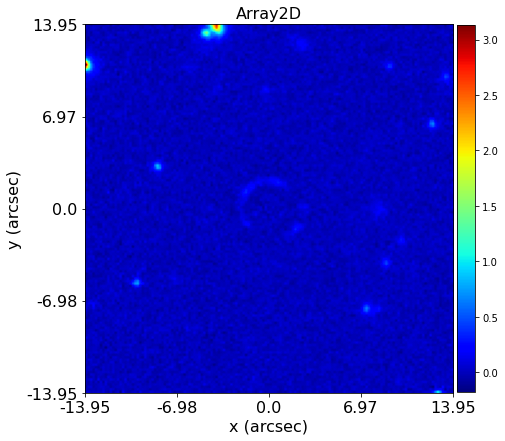

In [6]:
visuals_2d = aplt.Visuals2D()
array_plotter = aplt.Array2DPlotter(array=imaging.image, visuals_2d=visuals_2d)
array_plotter.figure_2d()

In [7]:
# Here, we just want to model our lens object. Keeping this in mind, we are going to use a circular mask of radius 3.5 arcsec
# to avoid unecessary processment and noise

# defining our mask
mask = al.Mask2D.circular(shape_native=imaging.shape_native, pixel_scales=pixel_scales, radius=3.5)
# applying our mask
imaging = imaging.apply_mask(mask=mask)

2022-04-13 14:36:11,350 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 1116 image-pixels


### Residual image after a mask 

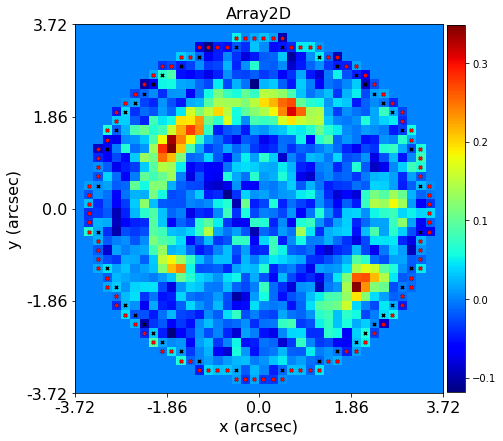

In [8]:
visuals_2d = aplt.Visuals2D()
array_plotter = aplt.Array2DPlotter(array=imaging.image, visuals_2d=visuals_2d)
array_plotter.figure_2d()

### Defining our model

In [9]:
# Lens and source redshifts
zl = 0.59
zs = 1.

# We define a bright object called bulge and combine it with our galaxy model. Here, we used a light sersic profile. If you want to read more about it, please visit https://en.wikipedia.org/wiki/Sérsic_profile
bulge = af.Model(al.lmp.EllSersic)
source_galaxy_model = af.Model(al.Galaxy,
                               redshift=zs,
                               bulge=bulge)
# Here, we have our lens model. As we already have an image with the lens light subtracted, we only use a mass profile (instead of light+mass), as a mass model we used SIE..
lens_galaxy_model = af.Model(al.Galaxy,
                             redshift=zl,
                             mass=al.mp.EllIsothermal)  
# Combining our galaxys into a single object
model = af.Collection(galaxies=af.Collection(lens=lens_galaxy_model, source=source_galaxy_model))

In our ./config path, we can also find model information that is not visually defined in this notebook. It has information about what cosmology we are using and the mathematical definitions about the profiles we used previously.

### Fitting our model

In [10]:
# Lets start to fit data and model!

# Lets define a search object, which is going to minimize our likelihood (PyAutoLens uses a Dynesty search: https://arxiv.org/abs/1904.02180 ) 
search = af.DynestyStatic(path_prefix = './', # Prefix path of our results
                          name = '211527',
                          unique_tag = 'source_light', # File path of our results
                          nlive = 50, # Number of live points of our dynesty sample
                          number_of_cores = 5) # Be carefull here! This corresponds to how much core of your cpu you are going to use!
analysis = al.AnalysisImaging(dataset=imaging) # Passing our data through the search
result = search.fit(model=model, analysis=analysis) # Finally fit our model

2022-04-13 14:36:12,428 - autofit.non_linear.abstract_search - INFO - Creating search
2022-04-13 14:36:12,432 - 211527 - INFO - Starting search
2022-04-13 14:36:14,711 - autolens.imaging.model.analysis - INFO - PRELOADS - Setting up preloads, may take a few minutes for fits using an inversion.
2022-04-13 14:36:15,392 - 211527 - INFO - Saving path info
2022-04-13 14:36:15,664 - 211527 - INFO - Not complete. Starting non-linear search.
2022-04-13 14:36:15,665 - 211527 - INFO - number_of_cores == 5...
2022-04-13 14:36:15,667 - 211527 - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-04-13 14:36:15,669 - process 0 - INFO - created
2022-04-13 14:36:15,671 - process 1 - INFO - created
2022-04-13 14:36:15,674 - process 2 - INFO - created
2022-04-13 14:36:15,678 - process 3 - INFO - created
2022-04-13 14:36:15,680 - process 4 - INFO - created
2022-04-13 14:36:15,767 - autofit.non_linear.initializer - INFO -

350it [01:29,  3.92it/s, +50 | bound: 41 | nc: 1 | ncall: 5064 | eff(%):  7.899 | loglstar:   -inf < 1488.153 <    inf | logz: 1476.598 +/-    nan | dlogz:  1.098 >  0.059] 


2022-04-13 14:37:46,791 - 211527 - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


599it [01:16,  7.85it/s, +50 | bound: 105 | nc: 1 | ncall: 10099 | eff(%):  6.426 | loglstar:   -inf < 1566.036 <    inf | logz: 1549.574 +/-    nan | dlogz:  1.082 >  0.059]


2022-04-13 14:39:33,449 - 211527 - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


1078it [01:12, 14.78it/s, +50 | bound: 186 | nc: 1 | ncall: 15102 | eff(%):  7.469 | loglstar:   -inf < 1705.264 <    inf | logz: 1679.365 +/-    nan | dlogz:  1.050 >  0.059]


2022-04-13 14:41:14,510 - 211527 - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


1847it [01:03, 29.12it/s, +50 | bound: 302 | nc: 1 | ncall: 20105 | eff(%):  9.435 | loglstar:   -inf < 1839.369 <    inf | logz: 1799.389 +/-    nan | dlogz:  0.464 >  0.059]


2022-04-13 14:42:48,858 - 211527 - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).


2695it [01:01, 43.82it/s, +50 | bound: 424 | nc: 1 | ncall: 25111 | eff(%): 10.931 | loglstar:   -inf < 1863.031 <    inf | logz: 1810.047 +/-    nan | dlogz:  0.013 >  0.059]


2022-04-13 14:44:25,456 - 211527 - INFO - 25000 Iterations: Performing update (Visualization, outputting samples, etc.).


3038it [00:26, 114.05it/s, +50 | bound: 481 | nc: 1 | ncall: 27266 | eff(%): 11.325 | loglstar:   -inf < 1867.428 <    inf | logz: 1810.105 +/-    nan | dlogz:  0.001 >  0.059]


2022-04-13 14:45:31,433 - 211527 - INFO - 30000 Iterations: Performing update (Visualization, outputting samples, etc.).


3038it [00:00, 320811.09it/s, +50 | bound: 481 | nc: 1 | ncall: 27266 | eff(%): 11.325 | loglstar:   -inf < 1867.428 <    inf | logz: 1810.105 +/-    nan | dlogz:  0.001 >  0.059]


2022-04-13 14:46:11,794 - 211527 - INFO - 35000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-04-13 14:46:50,254 - 211527 - INFO - 40000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-04-13 14:48:31,445 - 211527 - INFO - Removing zip file


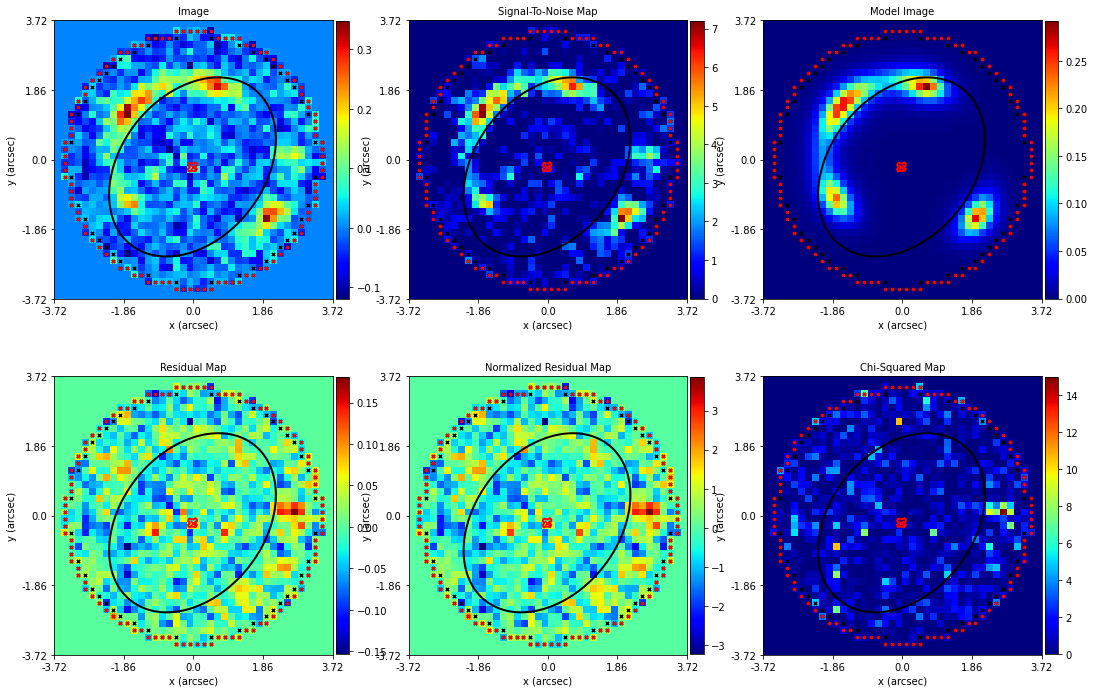

In [11]:
# Results of our fit!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

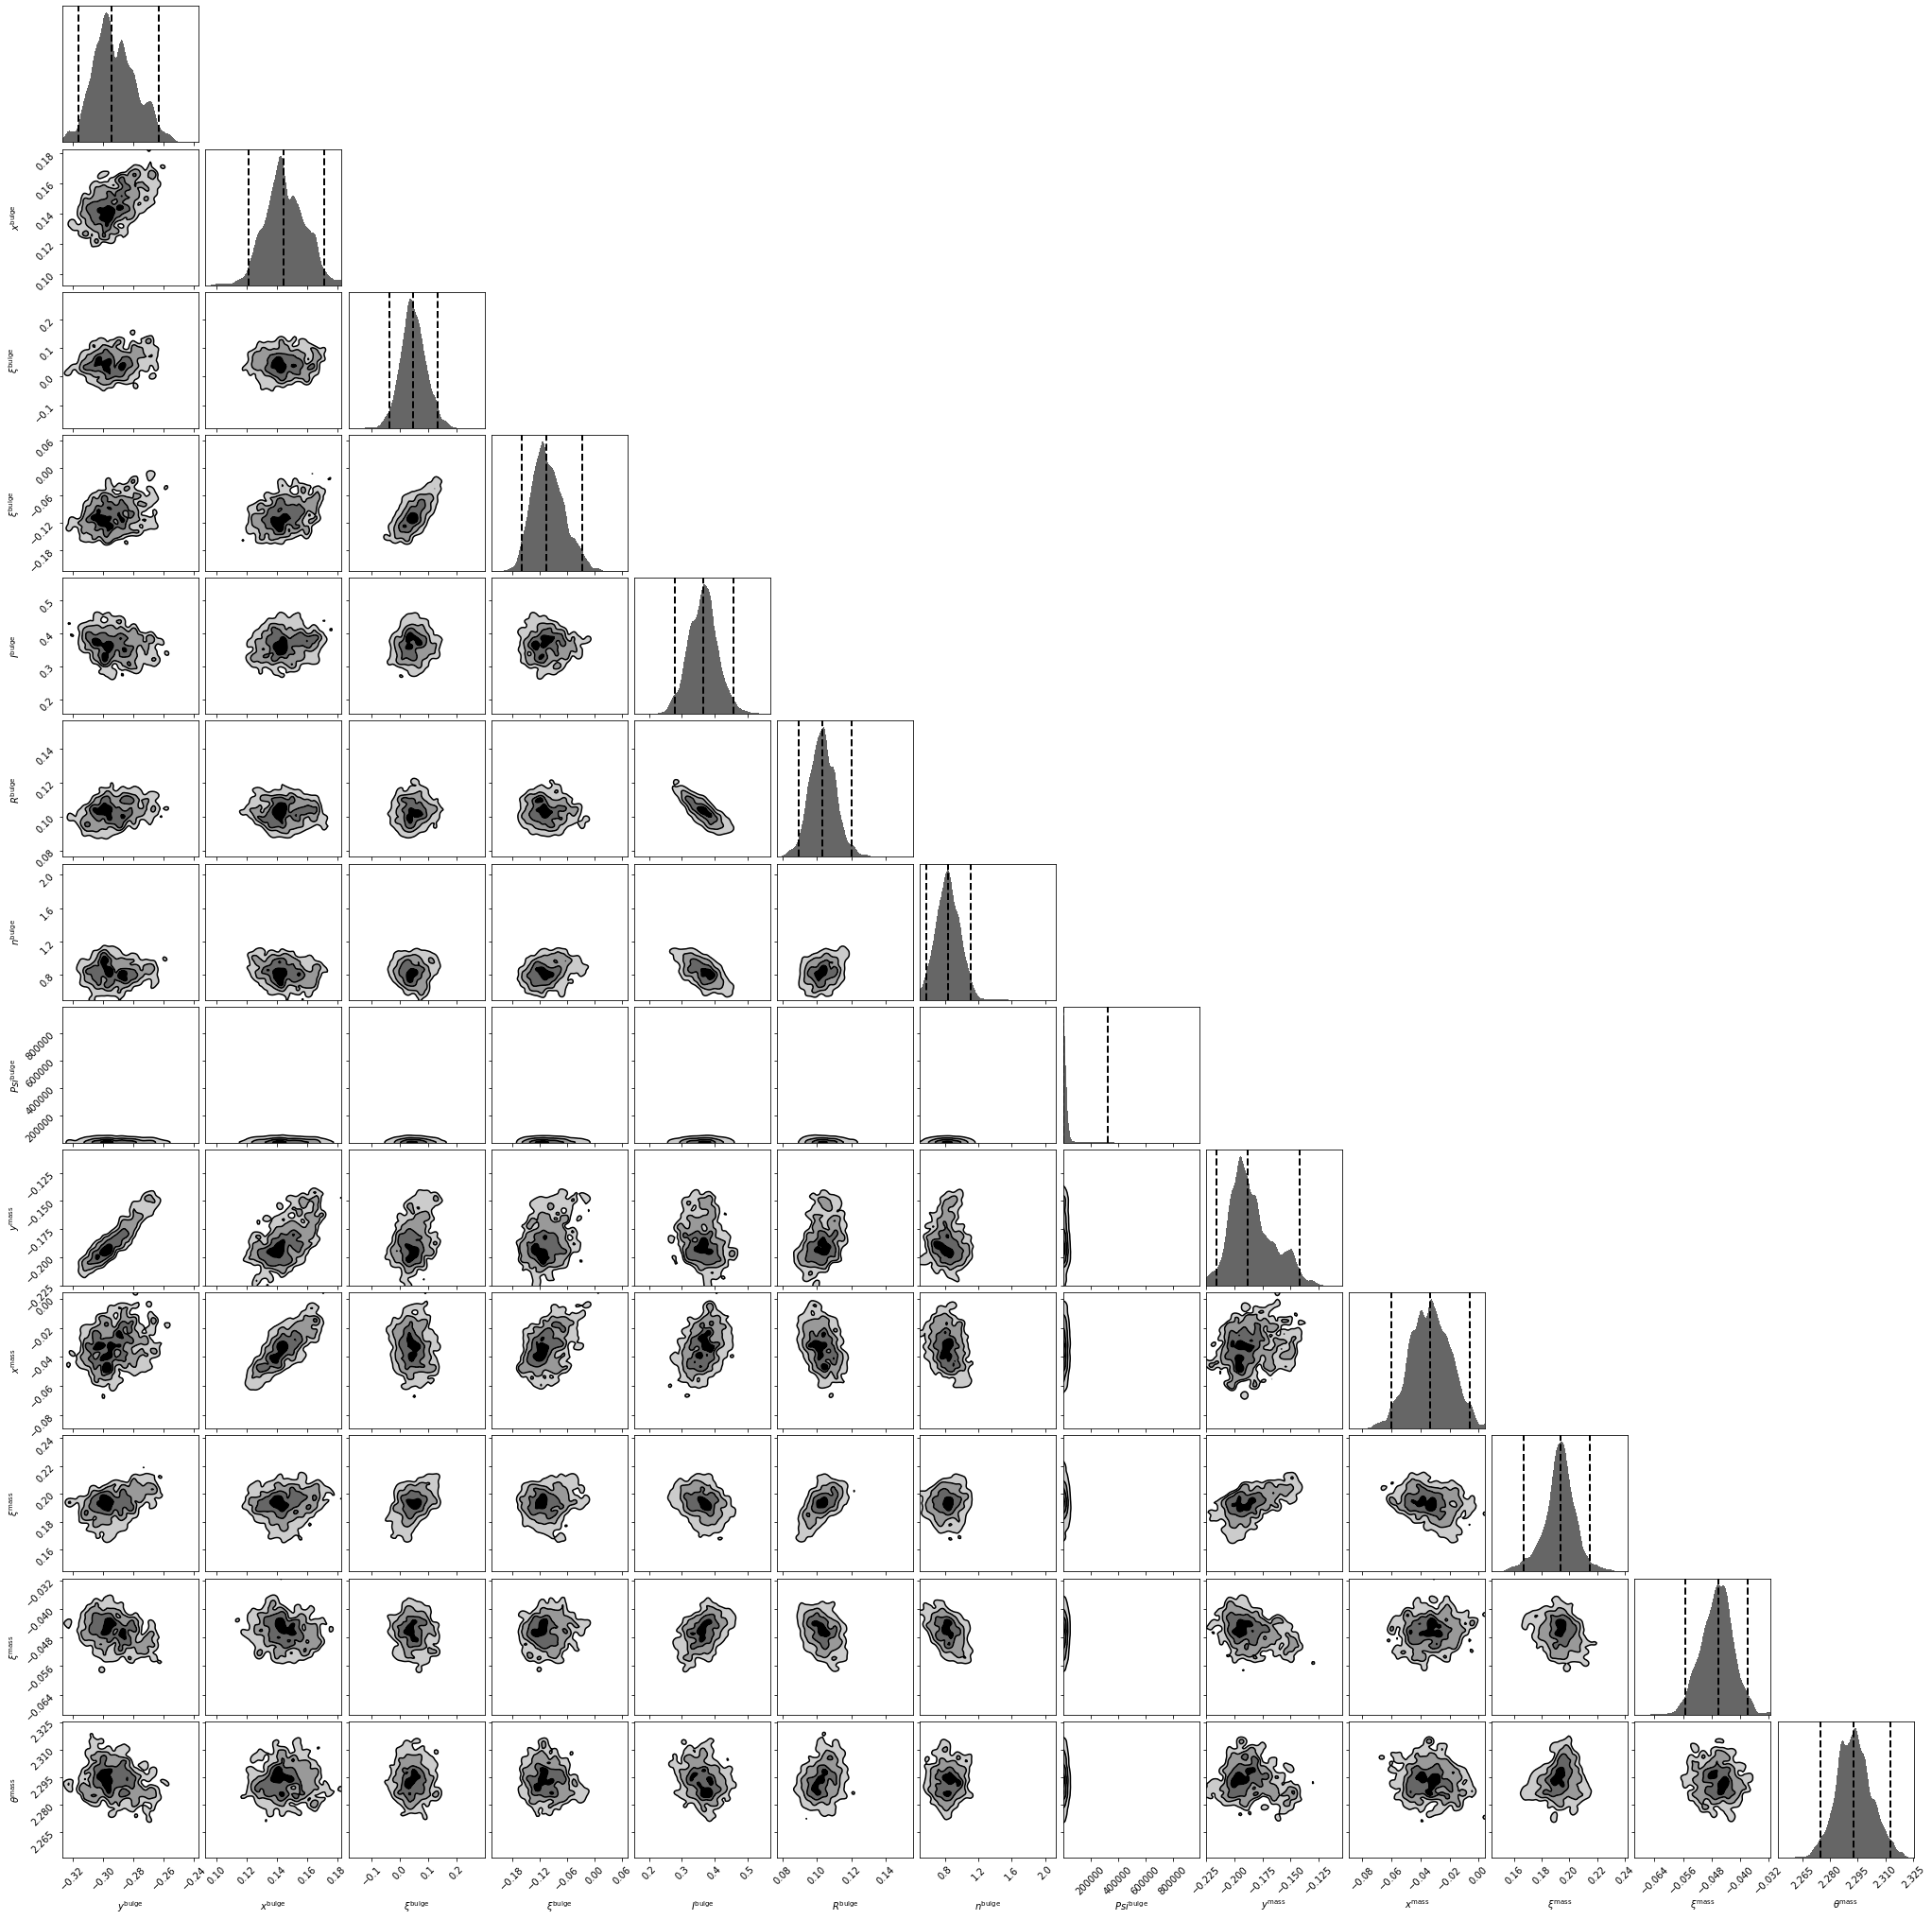

In [12]:
# sample and contour plots
dynesty_plotter = aplt.DynestyPlotter(samples=result.samples)
dynesty_plotter.cornerplot()